In [1]:
import random
import math
from tqdm.notebook import tqdm
from copy import copy
import matplotlib.pyplot as plt

In [2]:
# Generate an initial random population
def init_pop(pop_size, chromosome_length):
    ints = [random.randint(0,350) for i in range(pop_size)]
    strs = [bin(n)[2:].zfill(chromosome_length) for n in ints]
    bins = [[int(x) for x in n] for n in strs]
    return bins

In [3]:
# For a given population, calculate the fitness of each element in the population
def fitness_score(population):
    fitness_values = []
    num = []
    for i in range(len(population)):
        num.append(int("".join(str(x) for x in population[i]), base=2))  # convert binary to decimal
        fitness_values.append(-200 * math.pow(num[i],2) + 92000 * num[i] - 8400000)
    tuples = zip(*sorted(zip(fitness_values,population),reverse=True))
    fitness_values, population = [list(t) for t in tuples]
    return fitness_values, population

In [4]:
# Random parent selection
def select_parent(population, num_parents):
    parents=random.sample(population, num_parents)
    return parents

In [5]:
# Apply 1-point crossover
def crossover(parents, crossover_prob): 
    chromosome_length = len(parents[0]) 
    if crossover_prob > random.random():
        cross_point = random.randint(0,chromosome_length)
        parents+= tuple([(parents[0][0:cross_point +1] +parents[1][cross_point+1:(chromosome_length+1)])])
        parents+= tuple([(parents[1][0:cross_point +1] +parents[0][cross_point+1:(chromosome_length+1)])])
    return parents

This is a adaptive version of GA. We applied adaptive muation. 

1. Calculate the average fitness value of the population (f_avg);
2. For each chromosome, calculate its fitness value (f);
3. If f < f_avg, then this solution is regarded as a low-quality solution and thus the mutation rate should be kept high because this would increase the quality of this solution;
4. If f>f_avg, then this solution is regarded as a high-quality solution and thus the mutation rate should be kept low to avoid disrupting this high-quality solution.

In [6]:
# Alter each gene independently with a probability mutation_prob
def mutation(population, fitness_score, f_avg) :
    chromosome_length = len(population[0])
    for i in range(len(population)-1) :
        for j in range(chromosome_length-1) :
            if fitness_score[i] > f_avg:
                if population[i][j]==1:
                    population[i][j]=0
                else:
                    population[i][j]=1
    return population

In [7]:
def SGA(population, num_gen, num_parents, crossover_prob, mutation_prob, use_tqdm = False):
    states = []
    best_solution = []
    best_score = 0
    if use_tqdm: pbar = tqdm(total=num_gen)
    for _ in range(num_gen):
        if use_tqdm: pbar.update()
        # Get population fitness
        scores, population = fitness_score(population)
        f_avg = sum(scores)/len(scores)
        
        current_best_score = scores[0]
        current_best_solution = population[0]
        states.append(current_best_score)
        if current_best_score > best_score: 
            best_score = current_best_score
            best_solution = int("".join(str(x) for x in copy(current_best_solution)), base=2)
        parents = select_parent(population, num_parents)
        parents = crossover(parents, crossover_prob)
        population = mutation(population, scores, f_avg)
    return best_solution, best_score, states

In [8]:
# SGA Parameters
num_gen = 10000
pop_size = 5
crossover_prob = 0.7
mutation_prob = 0.3
num_parents = 2

# Solution representation
chromosome_length = 9
best_score = -100000 

# Initialize the "best solution"
population = init_pop(pop_size, chromosome_length)

  0%|          | 0/10000 [00:00<?, ?it/s]

Best Solution: 243
Best Score: 2146200.0


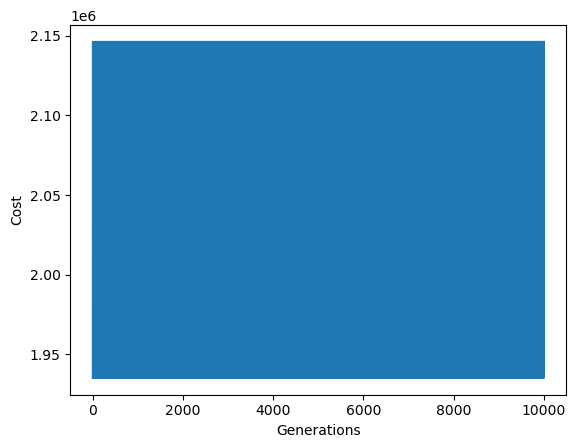

In [9]:
best_solution, best_score, states = SGA(
    population, num_gen, num_parents, crossover_prob, mutation_prob, use_tqdm=True
)

print(f"Best Solution: {best_solution}")
print(f"Best Score: {best_score}")
plt.plot(states)
plt.xlabel("Generations")
plt.ylabel("Cost")
plt.show()

## Routing example


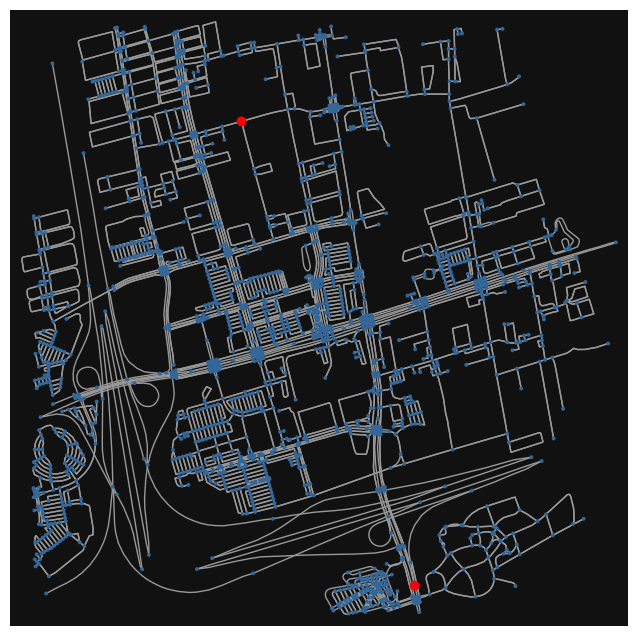

In [10]:
import osmnx

G = osmnx.graph_from_address('vaughan', dist=1400)

origin = 29658954
destination = 701446851

highlighted = [origin, destination]

nc = ['r' if node in highlighted else '#336699' for node in G.nodes()]
ns = [50 if node in highlighted else 8 for node in G.nodes()]
fig, ax = osmnx.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

In [11]:
from smart_mobility_utilities.children import shortest_path_with_failed_nodes_single
import random
import math

def mutate(G, route):
    source = route[0]
    destination = route[-1]

    failed = random.choice(route)

    path = shortest_path_with_failed_nodes_single(G, route, [failed])

    # This method could fail because of a lot of factors relating to the graph structure
    # Check the documentation fo the shortest_path_with_failed_nodes to learn more
    while path == math.inf:
        failed = random.choice(route)
        path = shortest_path_with_failed_nodes_single(G, route, [failed])
    
    return path

In [12]:
import itertools
from smart_mobility_utilities.common import probability

def cross_over(route_1, route_2):
    origin = route_1[0]
    destination = route_1[-1]

    intersection = [*itertools.filterfalse(\
                    lambda element : element in [origin, destination] ,\
                    list(set(route_1) & set(route_2)))]
    
    if len(intersection) == 0: return route_1 # if there is not common node, just return the first route

    cross_over_point = random.choice(intersection)
    first_point = route_1.index(cross_over_point)
    second_point = route_2.index(cross_over_point)

    if probability(0.50):
        return route_1[:first_point] + route_2[second_point:]
    else:
        return route_2[:second_point] + route_1[first_point:]

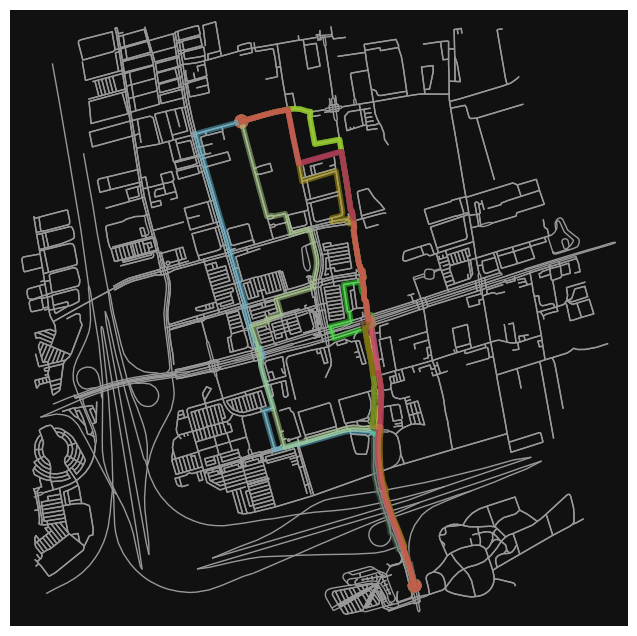

In [13]:
from smart_mobility_utilities.common import randomized_search

# Configure some parameters
n_gen = 100 # Anything above 20 will take some time but yield much better results
pool_size = 12 # Number of routes in each generation
parents_num = 4 # needs to be a factor of pool size

# Initialize the pool
pool = [randomized_search(G,origin,destination) for _ in range(pool_size)]

# Plot the pool on a map
random_hexa = lambda: random.randint(0,255) # generate random hexadecimal color
rc = ['#%02X%02X%02X' % (random_hexa(),random_hexa(),random_hexa()) for _ in range(pool_size)]
fig, ax = osmnx.plot_graph_routes(G, pool, route_colors=rc, route_linewidth=6, node_size=0)

In [14]:
from tqdm.notebook import tqdm
from smart_mobility_utilities.common import cost, flatten
from smart_mobility_utilities.children import get_children
import heapq

states = []

def select_best(pool, num_of_choices, probability_dist):
        return random.choices(population=pool, weights=probability_dist, k= num_of_choices)


for gen in tqdm(range(n_gen)):
    weights = [cost(G, route) for route in pool]
    parents_1 = select_best(pool, parents_num, weights)
    parents_2 = [cross_over(route_1, route_2) for route_1, route_2 in itertools.combinations(parents_1, r = 2)]
    pool.extend([mutate(G, route) for route in parents_2])
    pool = [*map(list, list(set(map(tuple, pool))))]
    num_removed = pool_size - len(pool) + 1
    pool.extend([randomized_search(G, origin, destination) for _ in range(num_removed)])
    pool = heapq.nsmallest(pool_size,pool,key=lambda x: cost(G,x))
    m = cost(G, min(pool, key = lambda route : cost(G, route)))
    states.append(m)

# Retrieve the final best route
route = min(pool, key=lambda route: cost(G,route))

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 